In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
model = 'resnext101_32x8d'
data_root_dir = 'data'
model_root_dir = 'models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  5794  images

Number of classes::  200
0 :: 001.Black_footed_Albatross :: 30
1 :: 002.Laysan_Albatross :: 30
2 :: 003.Sooty_Albatross :: 28
3 :: 004.Groove_billed_Ani :: 30
4 :: 005.Crested_Auklet :: 14
5 :: 006.Least_Auklet :: 11
6 :: 007.Parakeet_Auklet :: 23
7 :: 008.Rhinoceros_Auklet :: 18
8 :: 009.Brewer_Blackbird :: 29
9 :: 010.Red_winged_Blackbird :: 30
10 :: 011.Rusty_Blackbird :: 30
11 :: 012.Yellow_headed_Blackbird :: 26
12 :: 013.Bobolink :: 30
13 :: 014.Indigo_Bunting :: 30
14 :: 015.Lazuli_Bunting :: 28
15 :: 016.Painted_Bunting :: 28
16 :: 017.Cardinal :: 27
17 :: 018.Spotted_Catbird :: 15
18 :: 019.Gray_Catbird :: 29
19 :: 020.Yellow_breasted_Chat :: 29
20 :: 021.Eastern_Towhee :: 30
21 :: 022.Chuck_will_Widow :: 26
22 :: 023.Brandt_Cormorant :: 29
23 :: 024.Red_faced_Cormorant :: 22
24 :: 025.Pelagic_Cormorant :: 30
25 :: 026.Bronzed_Cowbird :: 30
26 :: 027.Shiny_Cowbird :: 30
27 :: 028.Brown_Creeper :: 29
28 :: 029.American_Crow :: 30
29 ::

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


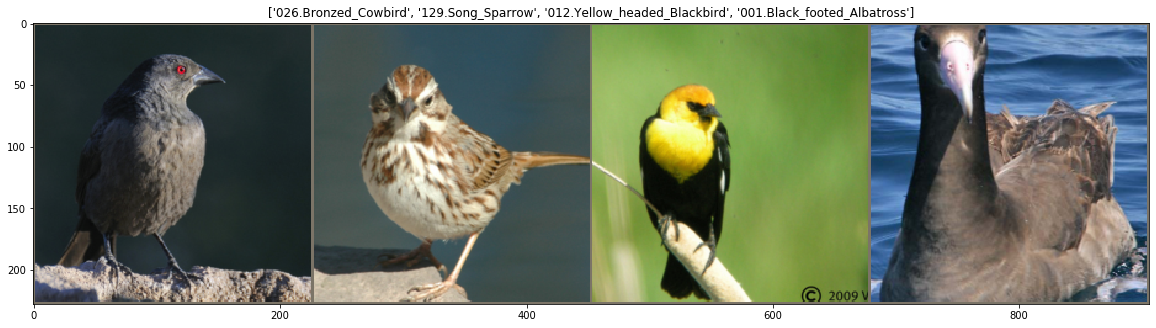

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Load the best model from file
model_ = torch.load(model_file)

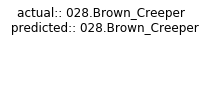

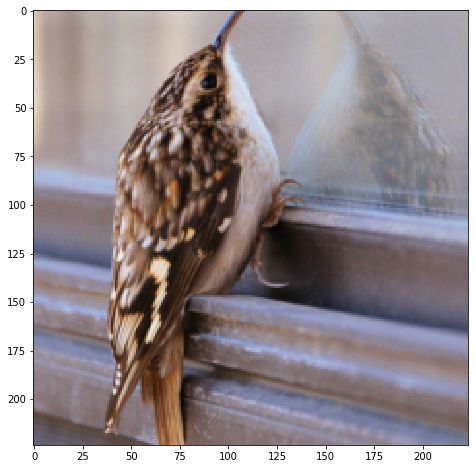

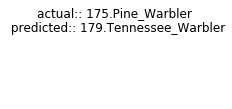

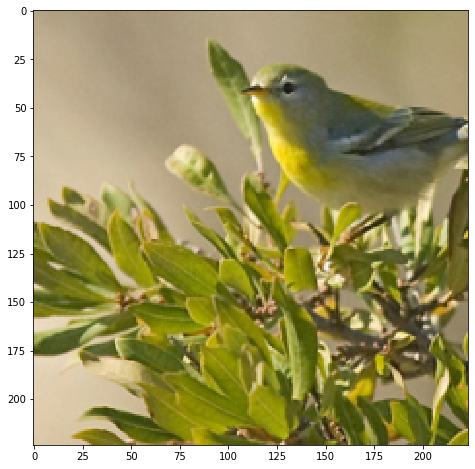

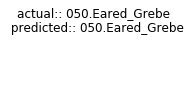

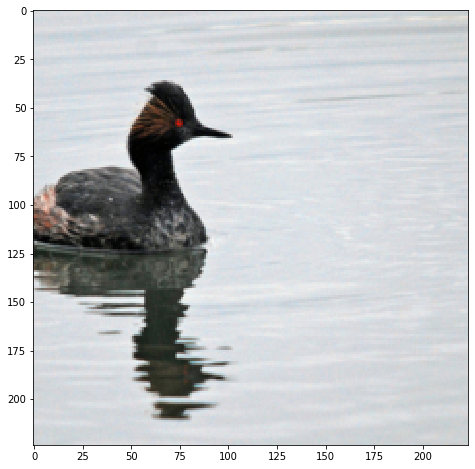

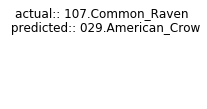

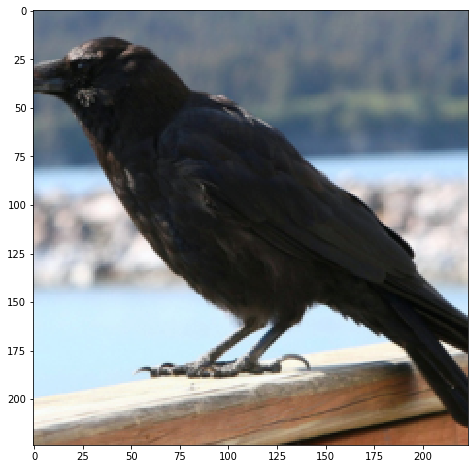

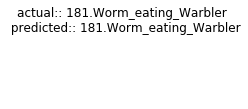

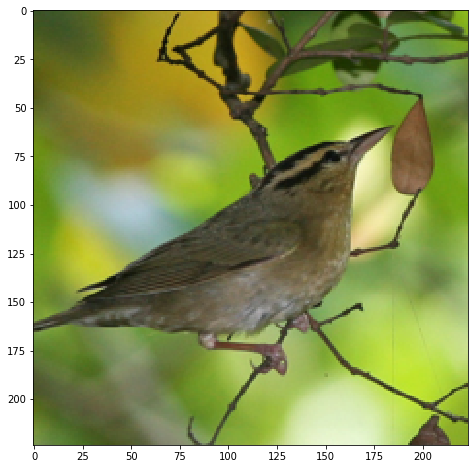

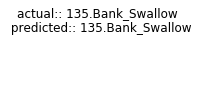

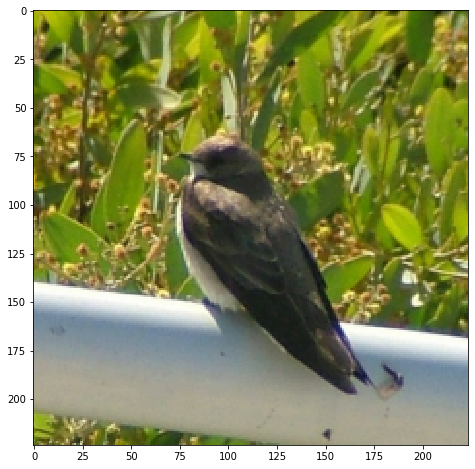

In [9]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [10]:
# Load model training history
history = unpickle(model_history)

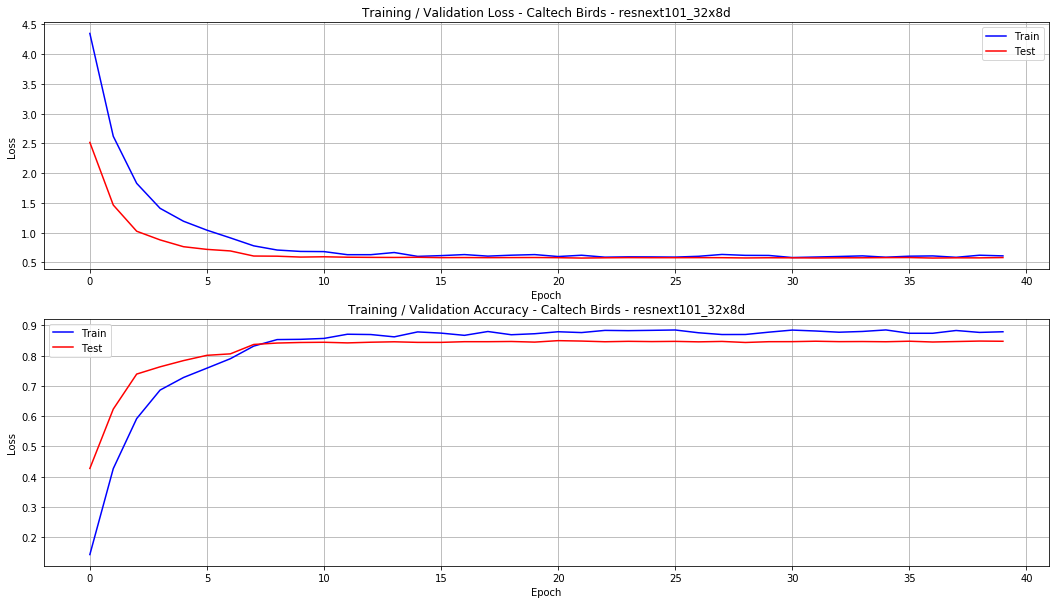

In [11]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [12]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))

print('Complete.')



Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [14]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.90      0.87      0.88        30
              002.Laysan_Albatross       0.90      0.90      0.90        30
               003.Sooty_Albatross       0.85      1.00      0.92        28
             004.Groove_billed_Ani       0.91      0.97      0.94        30
                005.Crested_Auklet       0.92      0.86      0.89        14
                  006.Least_Auklet       0.91      0.91      0.91        11
               007.Parakeet_Auklet       0.96      0.96      0.96        23
             008.Rhinoceros_Auklet       0.84      0.89      0.86        18
              009.Brewer_Blackbird       0.61      0.38      0.47        29
          010.Red_winged_Blackbird       1.00      0.97      0.98        30
               011.Rusty_Blackbird       0.74      0.67      0.70        30
       012.Yellow_headed_Blackbird       0.93      0.96      0.94        26
           

In [15]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

,001.Black_footed_Albatross,002.Laysan_Albatross,003.Sooty_Albatross,004.Groove_billed_Ani,005.Crested_Auklet,006.Least_Auklet,007.Parakeet_Auklet,008.Rhinoceros_Auklet,009.Brewer_Blackbird,010.Red_winged_Blackbird,...,194.Cactus_Wren,195.Carolina_Wren,196.House_Wren,197.Marsh_Wren,198.Rock_Wren,199.Winter_Wren,200.Common_Yellowthroat,accuracy,macro avg,weighted avg
precision,0.896552,0.9,0.848485,0.906250,0.923077,0.909091,0.956522,0.842105,0.611111,1.000000,...,0.931034,0.763158,0.888889,0.884615,0.875000,0.848485,1.000000,0.849672,0.853150,0.852961
recall,0.866667,0.9,1.000000,0.966667,0.857143,0.909091,0.956522,0.888889,0.379310,0.966667,...,0.900000,0.966667,0.800000,0.766667,0.933333,0.933333,0.933333,0.849672,0.850970,0.849672
f1-score,0.881356,0.9,0.918033,0.935484,0.888889,0.909091,0.956522,0.864865,0.468085,0.983051,...,0.915254,0.852941,0.842105,0.821429,0.903226,0.888889,0.965517,0.849672,0.849235,0.848474
support,30.000000,30.0,28.000000,30.000000,14.000000,11.000000,23.000000,18.000000,29.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.849672,5794.000000,5794.000000


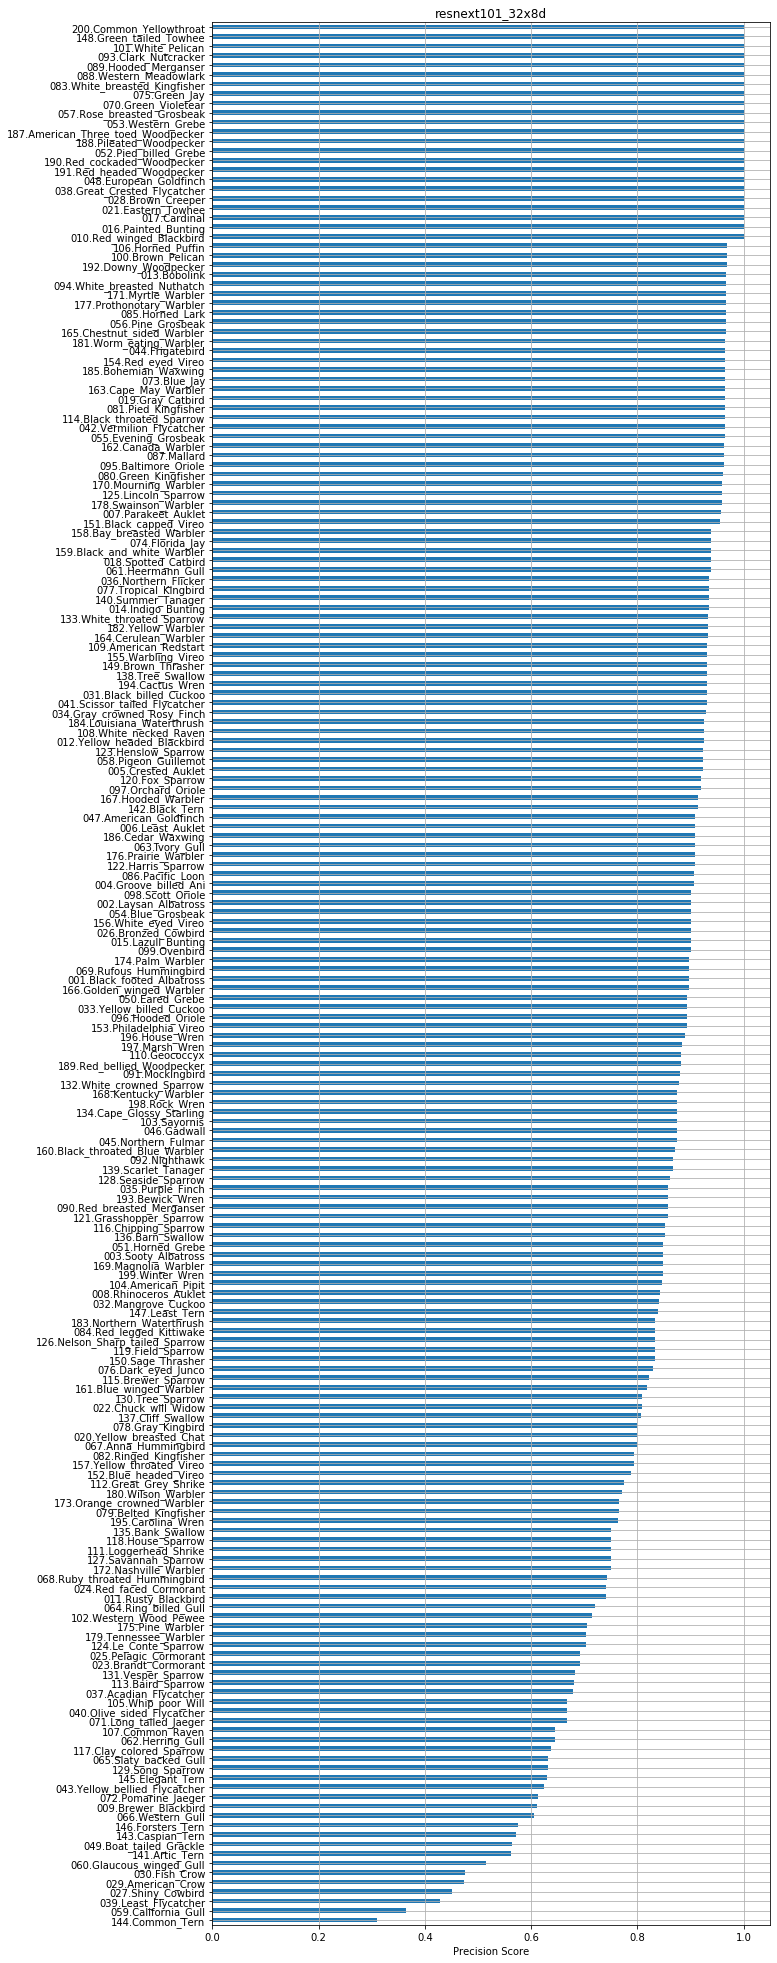

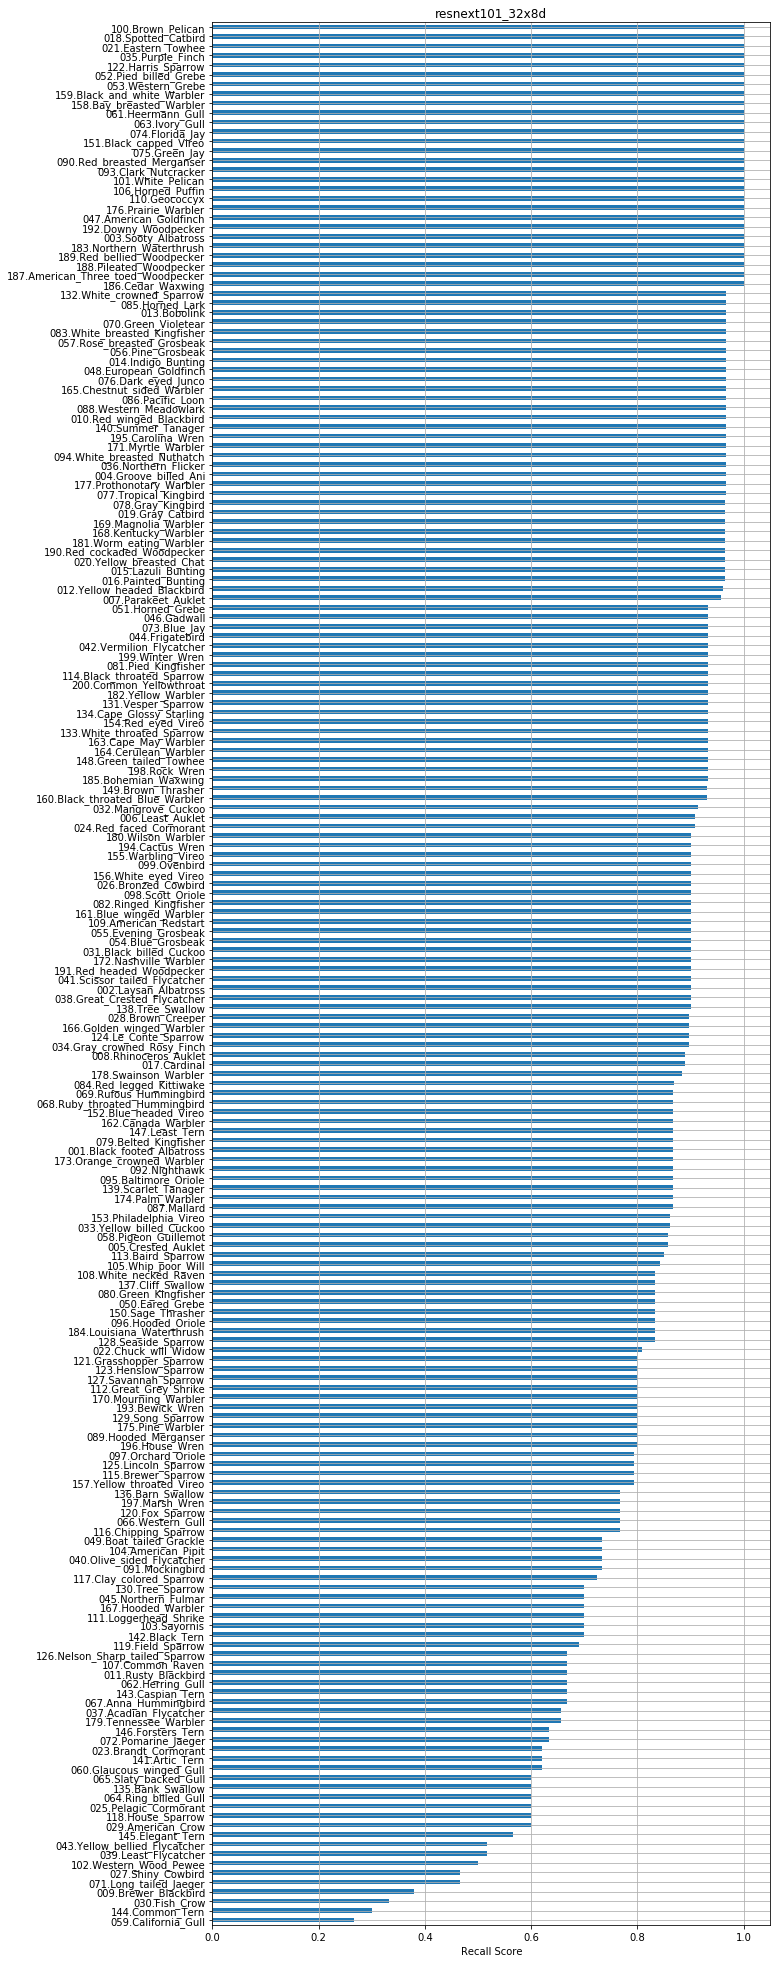

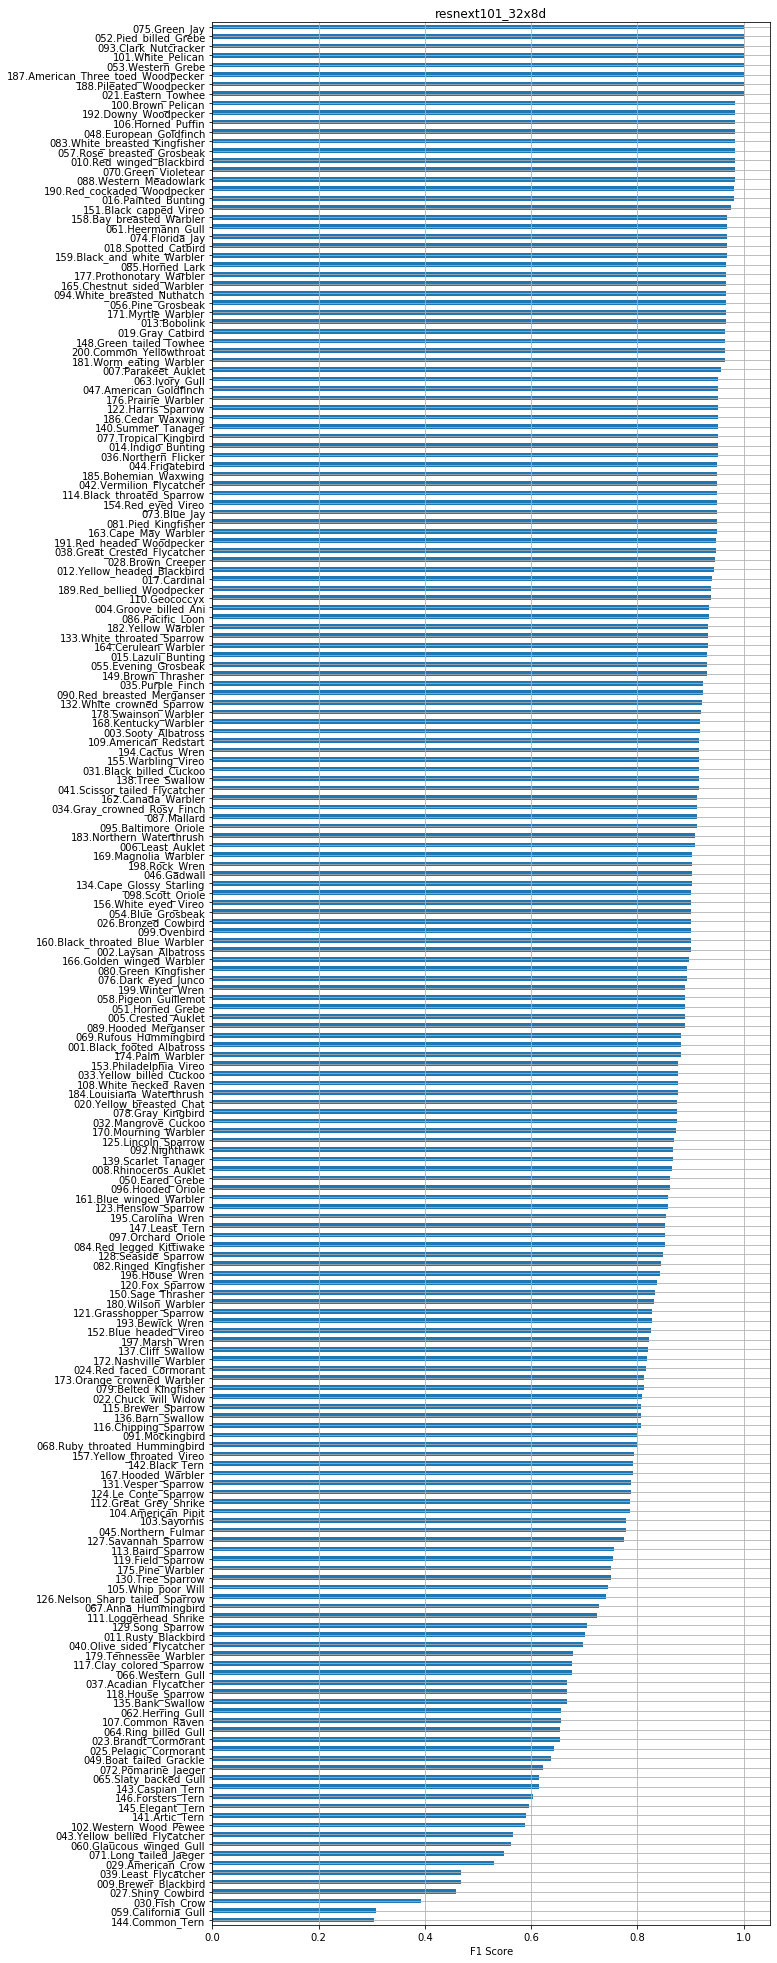

In [16]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [17]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

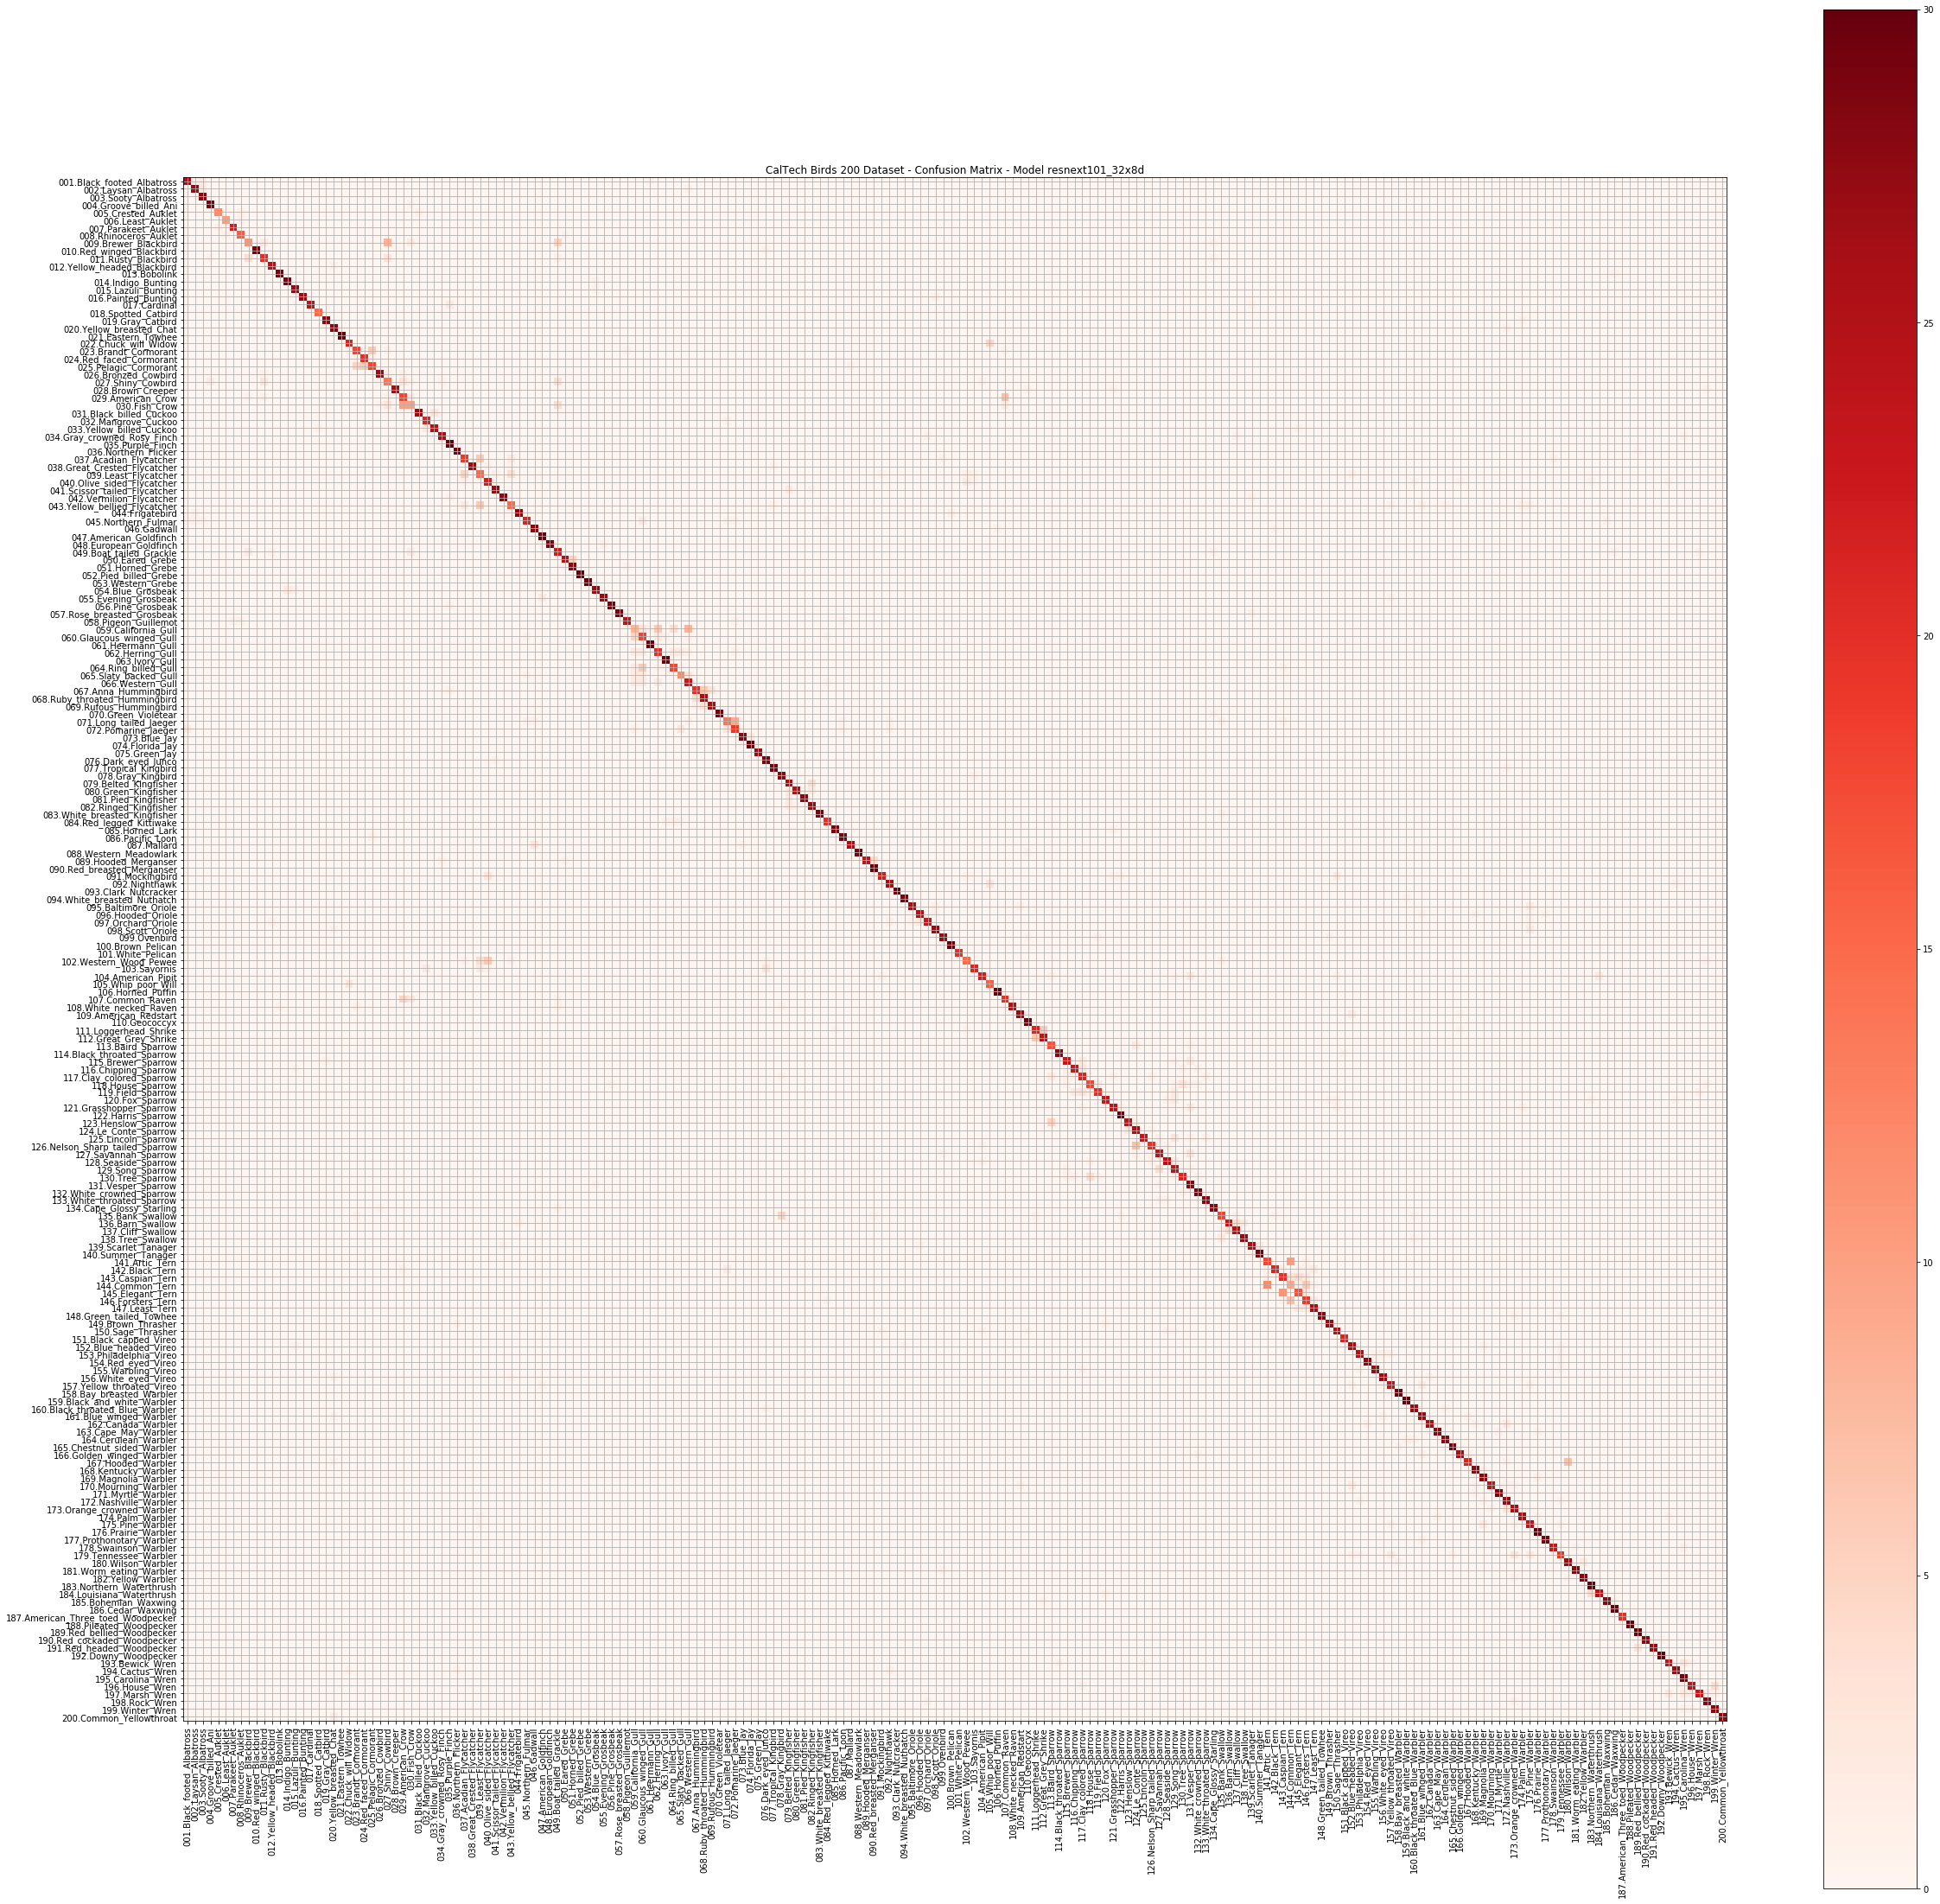

In [18]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [19]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))